# Using deep learning to solve a classification problem

In this notebook we will walk through a whole production process of creating a model that will be able to classify pictures of different types of Costa Rican wildlife.


fastai is an open source library that sits on top of pytorch and provides a consistent api to deep learning applications

In [2]:
# This line is to install fastai libraries
# hide pip install line if necessary

! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
# hide if necessary
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# If you dont have a key yet, go to azure and create a search resource
# this will allow you to download images from bing
key = os.environ.get('AZURE_SEARCH_KEY', 'KEY')

In [5]:
# function provided by utils class
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

We want to make sure that the function is working, at this time a result from a search with the function will produce 150 links, we also want to make sure that the links we are using are what we are looking for.

In [6]:
results = search_images_bing(key, 'toucan')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
ims = ['http://www.thelivingcoast.org/wp-content/uploads/2015/04/TocoToucan.jpg']

In [10]:
dest = 'images/toucan.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

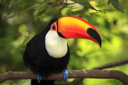

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

Now we will download all the images from the urls provided by the search function. We will also decide on what type of wildlife we will classify.

In [13]:
wildlife_types = 'toucan', 'rainforest frog', 'sea turtle'
path = Path('wildlife')

In [14]:
if not path.exists():
    path.mkdir()
    for o in wildlife_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'costa rica {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [15]:
fns = get_image_files(path)
fns

(#431) [Path('wildlife/rainforest frog/005a7d8b-056c-4171-9de7-2745a438ead2.jpg'),Path('wildlife/rainforest frog/00624cce-3d3e-4a76-b7f4-03c3afdfc864.jpeg'),Path('wildlife/rainforest frog/0087709f-d447-477b-a2e5-0b8e9a725db4.jpg'),Path('wildlife/rainforest frog/016e8b54-6b58-4ea8-9c5c-07a143188765.jpg'),Path('wildlife/rainforest frog/03e84d62-9c29-4482-ba4c-0e2d0e39bca9.jpg'),Path('wildlife/rainforest frog/05dcaf8e-feae-4ac2-b4d2-6c6fed6d62fb.jpg'),Path('wildlife/rainforest frog/06148b8e-9f46-4641-8b79-d4aa27e94d1f.jpg'),Path('wildlife/rainforest frog/066f82a5-ee93-4a18-aab0-3535e2119445.jpg'),Path('wildlife/rainforest frog/06ad8810-837d-4505-bb21-3608b77ac0c2.jpg'),Path('wildlife/rainforest frog/06f09bf2-ecfd-442c-80ff-68bba3be5195.jpg')...]

Check if there are any corrupt files

In [17]:
failed = verify_images(fns)
failed

(#8) [Path('wildlife/rainforest frog/44c5f890-b2f0-4a8a-8352-560a5001710f.jpg'),Path('wildlife/rainforest frog/910fbc50-b80f-4b30-918d-02d2275bd110.jpg'),Path('wildlife/rainforest frog/92bfa8e4-7d1f-41ef-9e8d-1703bf9f64b3.jpg'),Path('wildlife/rainforest frog/955d1c7c-42b8-412c-92d7-f29b835ee942.jpg'),Path('wildlife/rainforest frog/fb90b476-ee73-4a87-9fe8-2d4e727ce2f4.jpg'),Path('wildlife/sea turtle/6d7b3114-0c1f-41dc-ad0d-8abafee5cb3a.jpg'),Path('wildlife/toucan/bc19daf7-1df0-4f54-a5df-b5ee2bb074a7.jpg'),Path('wildlife/toucan/ec04352b-c207-4fac-8275-66531f77a964.jpg')]

unlink failed images

In [19]:
failed.map(Path.unlink);

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model.

When we run the show_batch function we will see something like this:
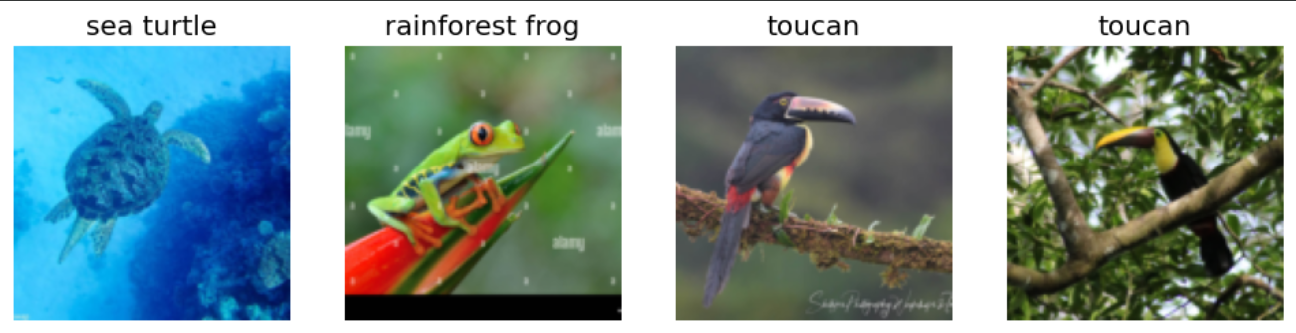

In [28]:
wildlife = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=43),
    get_y=parent_label,
    item_tfms=Resize(128))

In [29]:
dls = wildlife.dataloaders(path)

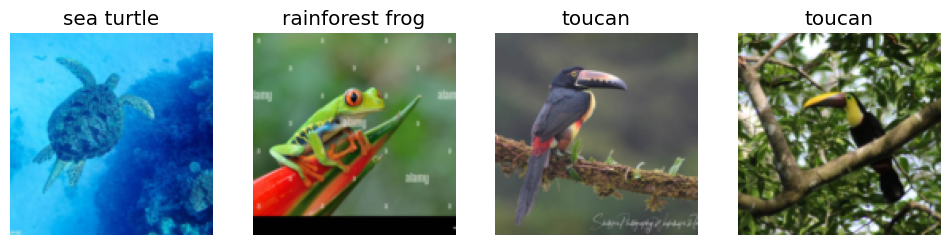

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

We have to resize our images so that they can be used as training data by the neural network. You can squish images, or pad the images, but these methods could be problomatic.

If we crop images our model can learn to focus on, and recognize, different features in our images.

It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

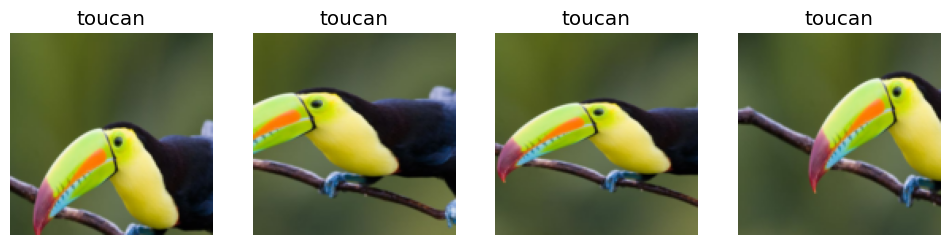

In [32]:
wildlife = wildlife.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = wildlife.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Now we will use data augmentation

Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

If we have gpu support we can augment an entire batch of images at the same time because all of our images are the same size.

This is an example of data augmentation applied to an image:
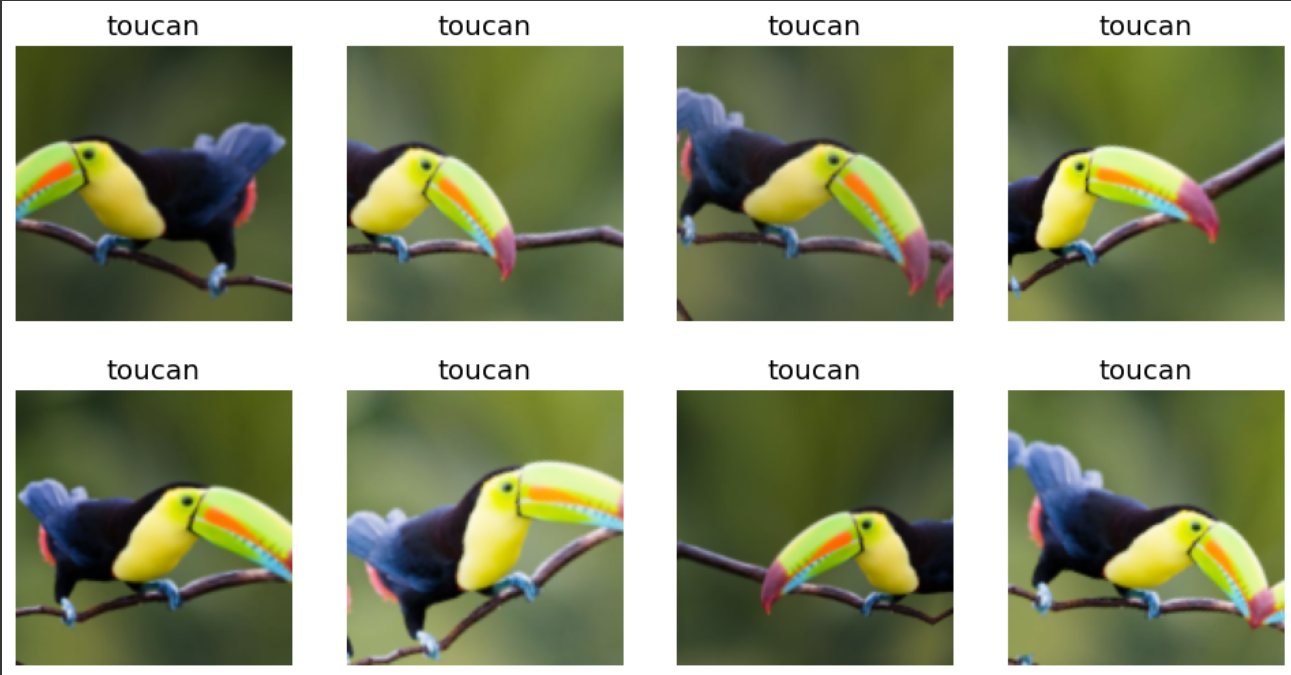

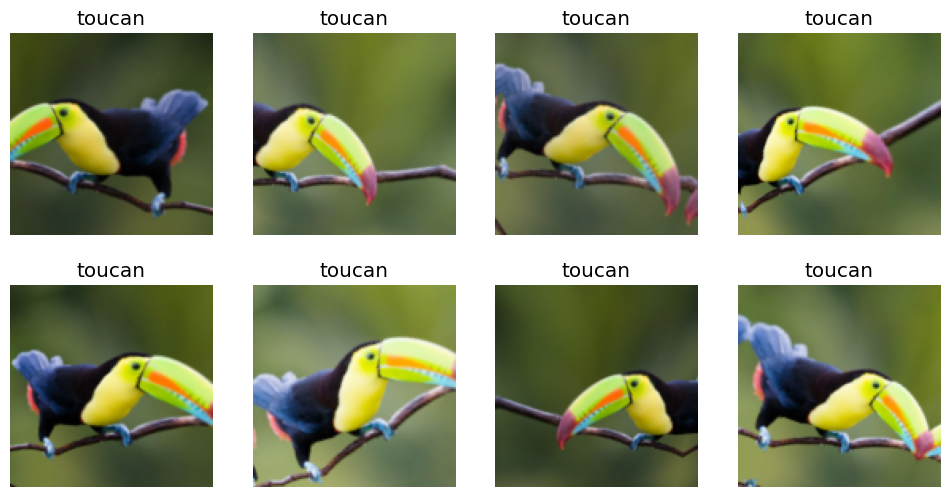

In [33]:
wildlife = wildlife.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = wildlife.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now we will train the model. We need to make the correct data augmentation and also create our learner. We will use a resnet18 architecture.

In [35]:
wildlife = wildlife.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = wildlife.dataloaders(path)

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\Josue\.conda\envs\DataScience23\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Josue\.conda\envs\DataScience23\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Josue/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.74MB/s]


This is the display of the training process.
As you can see the loss and error are going down, so that is a good sign

    epoch 	train_loss 	valid_loss 	error_rate 	time


    0 	1.104998 	0.068421 	0.023810 	00:38


    epoch 	train_loss 	valid_loss 	error_rate 	time


    0 	0.103891 	0.023508 	0.011905 	00:55


    1 	0.070112 	0.008758 	0.000000 	00:54


    2 	0.050726 	0.004867 	0.000000 	00:55


    3 	0.038424 	0.003885 	0.000000 	00:55

Now we will display a confusion matrix

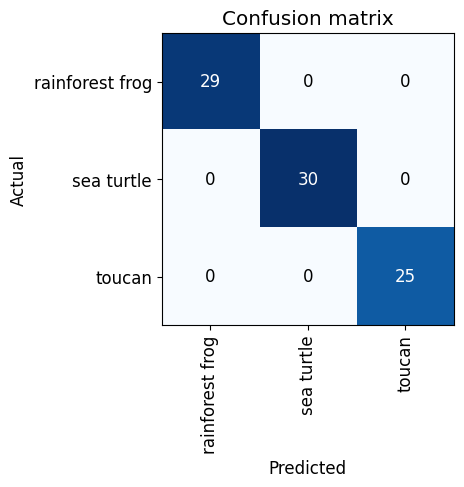

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

This model is really good at categorizing the wildlife.

These next lines of code can be used to understand what training data the model struggled to categorize and it provides an easy way to clean the data.

Depending on your system the interface might not be able to be dispalyed correctly.

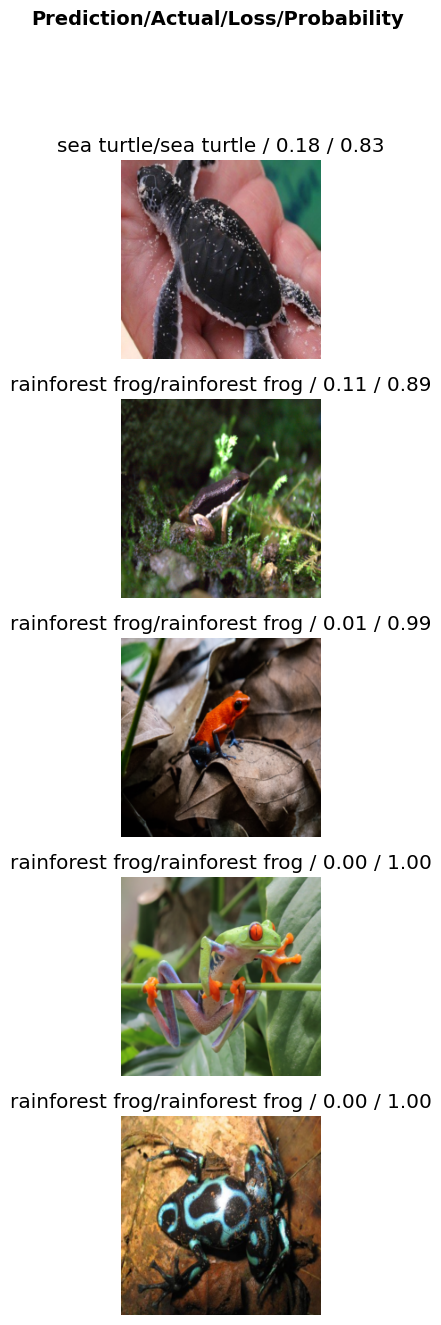

In [43]:
interp.plot_top_losses(5, nrows=5)

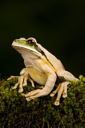

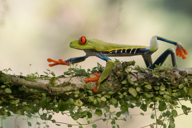

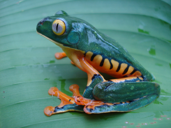

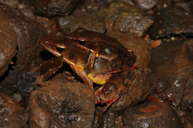

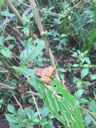

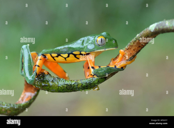

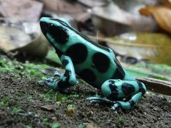

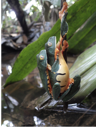

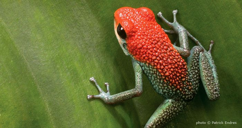

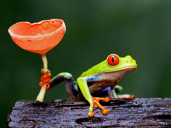

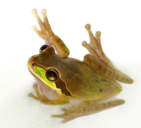

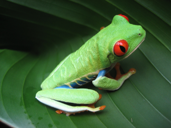

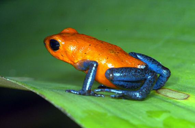

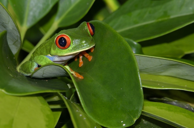

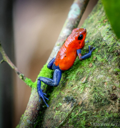

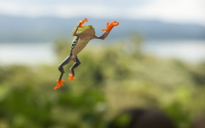

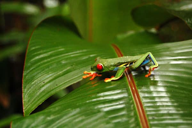

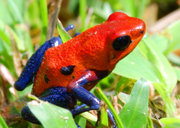

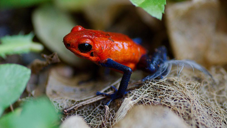

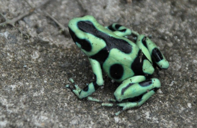

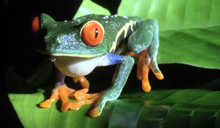

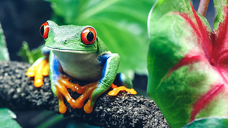

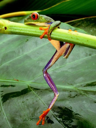

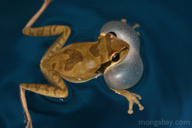

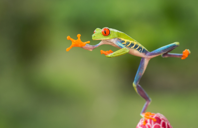

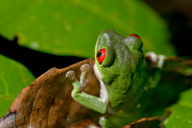

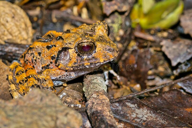

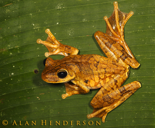

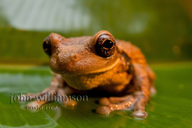

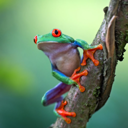

In [44]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [45]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now we will save the model.

In [46]:
learn.export()

In [47]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

We will now load the model and use it to classify an image.

fastai provides a nice interface to do this.

In [48]:
learn_inf = load_learner(path/'export.pkl')

In [49]:
learn_inf.dls.vocab

['rainforest frog', 'sea turtle', 'toucan']

In [50]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [51]:
btn_upload = SimpleNamespace(data = ['images/toucan.jpg'])

In [52]:
img = PILImage.create(btn_upload.data[-1])

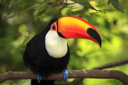

Output()

In [54]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [55]:
pred,pred_idx,probs = learn_inf.predict(img)

## We will now display the prediction of the model!!!

In [56]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: toucan; Probability: 1.0000')

The following code creates a button, it will work depending on your environment

In [57]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [61]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [59]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [60]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])